# Zero-shot vs Supervised for text classification

## Installs

In [ ]:
!pip install datasets
!pip install -q transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.1/311.1 kB 23.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 33.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 64.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 54.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 20.8 MB/s eta 0:00:00


### Imports

In [ ]:
import logging
from datasets import load_dataset
import pandas as pd
import numpy as np
from numpy import random
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import re
%matplotlib inline



### load dataset

In [ ]:
dataset = load_dataset("okite97/news-data")

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [ ]:
len(dataset["test"])

828

In [ ]:
data = pd.DataFrame(dataset["test"])

In [ ]:
data.Category.unique()

array(['politics', 'business', 'health', 'sports', 'tech',
       'entertainment'], dtype=object)

In [ ]:
data.head()

,Title,Excerpt,Category
0,Nigeria: Cross River Governor Ayade Dumps PDP ...,"Cross River State Governor, Ben Ayade has defe...",politics
1,Electoral Bill: Nigeria Senate Mobilises to Ov...,Nigerians have not heard the last of President...,politics
2,Nigeria: Central Bank Increases Forex Allocati...,The Central Bank of Nigeria (CBN) on Sunday an...,business
3,Nigeria to Set Up Fund to Cover 83m Poor Citiz...,President Muhammadu Buhari has signed into law...,health
4,World Bank Revises Sub-Saharan Africa’s Growth...,The World Bank has revised its growth forecast...,business


Combine title and Excerpt

In [ ]:
data['combined_text'] = data['Title'].astype(str) + '. ' + data['Excerpt']

## Zero-shot classification

### Related Definitions
*  **Zero-shot text classification** is a natural language processing task where a model is asked to classify text into predefined categories, even if it has never seen examples of those specific categories during training. The model uses its general understanding of language and concepts to make predictions.





In [ ]:
from transformers import pipeline

pipe = pipeline(model="facebook/bart-large-mnli")

In [ ]:
def extract_highest_score_label(data):
    # Extract labels and scores
    labels = data['labels']
    scores = data['scores']

    # Pair labels and scores using zip
    label_score_pairs = zip(labels, scores)

    # Find the label with the highest score
    max_label, max_score = max(label_score_pairs, key=lambda x: x[1])

    max_score_percentage = round(max_score * 100, 2)

    return max_label, max_score_percentage

In [ ]:
texts = []
category = []
category_percentage = []

In [ ]:
# %%time
# count = 0
# for i in data['combined_text'][:]:
#   texts.append(pipe(i,candidate_labels=["business", "sports", "politics", "health", "entertainment", "tech"])['sequence'])
#   max_label, max_score = extract_highest_score_label(pipe(i,candidate_labels=["business", "sports", "politics", "health", "entertainment", "tech"]))
#   if count%100==0:
#     print(count)
#   category.append(max_label)
#   category_percentage.append(max_score)
#   count += 1

In [ ]:
zero_shot_data = {
    "article": texts,
    "category_label": category,
    "category(%)": category_percentage
}

In [ ]:
zero_pd_test = pd.DataFrame(zero_shot_data)

In [ ]:
read_zero_data = pd.read_csv('zero_shot_data.csv')

In [ ]:
zero_pd_test = pd.DataFrame(read_zero_data)

In [ ]:
zero_pd_test.head()

,Unnamed: 0,article,category_label,category(%)
0,0,Nigeria: Cross River Governor Ayade Dumps PDP ...,politics,88.86
1,1,Electoral Bill: Nigeria Senate Mobilises to Ov...,politics,66.63
2,2,Nigeria: Central Bank Increases Forex Allocati...,business,44.26
3,3,Nigeria to Set Up Fund to Cover 83m Poor Citiz...,health,59.94
4,4,World Bank Revises Sub-Saharan Africa’s Growth...,tech,31.66


In [ ]:
# zero_pd_test.to_csv('zero_shot_data.csv')

### Determine accuracy

In [ ]:
def get_zero_shot_efficiency(zero_pd_test, data):
    count = 0
    # Ensure both DataFrames have the same number of rows
    if len(zero_pd_test) != len(data):
        return "DataFrames have different lengths"

    # Iterate through the rows
    for i in range(len(zero_pd_test)):
        category_label_test = zero_pd_test.loc[i, 'category_label']
        category_data = data.loc[i, 'Category']

        if category_label_test == category_data:
            count += 1
    accuracy = (count/len(data))*100
    return accuracy

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

def get_zero_shot_metrics(zero_pd_test, data):
    # Ensure both DataFrames have the same number of rows
    if len(zero_pd_test) != len(data):
        return "DataFrames have different lengths"

    # Initialize variables for metrics
    true_positives = 0
    false_positives = 0
    false_negatives = 0

    # Iterate through the rows
    for i in range(len(zero_pd_test)):
        category_label_test = zero_pd_test.loc[i, 'category_label']
        category_data = data.loc[i, 'Category']

        if category_label_test == category_data:
            true_positives += 1
        else:
            false_negatives += 1
            false_positives += 1

    # Calculate macro-averaged metrics
    macro_precision = precision_score(data['Category'], zero_pd_test['category_label'], average='macro')
    macro_recall = recall_score(data['Category'], zero_pd_test['category_label'], average='macro')
    macro_f1 = f1_score(data['Category'], zero_pd_test['category_label'], average='macro')

    # Calculate weighted-averaged metrics
    weighted_precision = precision_score(data['Category'], zero_pd_test['category_label'], average='weighted')
    weighted_recall = recall_score(data['Category'], zero_pd_test['category_label'], average='weighted')
    weighted_f1 = f1_score(data['Category'], zero_pd_test['category_label'], average='weighted')

    return {
        'macro_precision': macro_precision,
        'macro_recall': macro_recall,
        'macro_f1': macro_f1,
        'weighted_precision': weighted_precision,
        'weighted_recall': weighted_recall,
        'weighted_f1': weighted_f1
    }


In [ ]:
# accuracy
get_zero_shot_efficiency(zero_pd_test, data)

70.41062801932367

In [ ]:
# Precision, Recall and F1 score
metrics = get_zero_shot_metrics(zero_pd_test, data)
print("Macro Precision:", metrics['macro_precision'])
print("Macro Recall:", metrics['macro_recall'])
print("Macro F1 Score:", metrics['macro_f1'])
print("Weighted Precision:", metrics['weighted_precision'])
print("Weighted Recall:", metrics['weighted_recall'])
print("Weighted F1 Score:", metrics['weighted_f1'])

Macro Precision: 0.7227526043377127
Macro Recall: 0.6740810194641997
Macro F1 Score: 0.6742957295562522
Weighted Precision: 0.7897905269358944
Weighted Recall: 0.7041062801932367
Weighted F1 Score: 0.7340100545817861


## Supervised learning approach

### Related definitions

*  **Multiclass classification** in machine learning is a task where the goal is to assign an input data point to one of multiple possible classes or categories. Unlike in Binary classification where there are only 2 options (i.e. yes/no), Multiclass involves more than 2 mutually exclusive classes.

* **Naive Bayes** is a probabilistic machine learning algorithm that's used to assign input data to one of multiple classes. It's an extension of the Naive Bayes algorithm, which is commonly used for binary classification.

* **Linear SVM** is a machine learning tool for sorting data into different groups. It does this by finding the best straight line (hyperplane) that creates the most space (margin) between these groups when they can be separated with a straight line.

*  **Logistic regression** is a statistical and machine learning technique used to predict the probability of an input data point belonging to one of multiple classes. Unlike binary logistic regression, which is used for two-class problems, multiclass logistic regression can handle more than two classes.

In [ ]:
df = pd.DataFrame(dataset['train'])

In [ ]:
df.head(10)

,Title,Excerpt,Category
0,"Uefa Opens Proceedings against Barcelona, Juve...",Uefa has opened disciplinary proceedings again...,sports
1,Amazon Blames Inflation as It Increases Cost o...,The increases are steeper than the 17 percent ...,business
2,Nigeria’s Parliament Passes Amended Electoral ...,Nigeria's Senate on Tuesday passed the harmoni...,politics
3,Nigeria: Lagos Governor Tests Positive for Cov...,"The Lagos State Governor, Mr. Babajide Sanwo-O...",health
4,South Africa Calls For Calm as Electoral Refor...,South Africa has raised concerns about the det...,politics
5,Guardiola To Leave Man City When Contract Expi...,Pep Guardiola has said that he will leave Manc...,sports
6,Nigeria: Sultan of Sokoto Seeks Removal of Imm...,The Sultan of Sokoto and President-General of ...,politics
7,"Again, Nigeria Senate Demands Rejig of Nigeria...",Nigerian Senators have commenced legislative a...,politics
8,Nigeria: South-East’s Most Important Demand i...,Former Senate President and presidential hopef...,politics
9,Premier League Clubs Reject ‘Project Big Picture’,"Premier League clubs have ""unanimously agreed""...",sports


In [ ]:
df['combined_text'] = df['Title'].astype(str) + '. ' + df['Excerpt']

In [ ]:
df.head(10)

,Title,Excerpt,Category,combined_text
0,"Uefa Opens Proceedings against Barcelona, Juve...",Uefa has opened disciplinary proceedings again...,sports,"Uefa Opens Proceedings against Barcelona, Juve..."
1,Amazon Blames Inflation as It Increases Cost o...,The increases are steeper than the 17 percent ...,business,Amazon Blames Inflation as It Increases Cost o...
2,Nigeria’s Parliament Passes Amended Electoral ...,Nigeria's Senate on Tuesday passed the harmoni...,politics,Nigeria’s Parliament Passes Amended Electoral ...
3,Nigeria: Lagos Governor Tests Positive for Cov...,"The Lagos State Governor, Mr. Babajide Sanwo-O...",health,Nigeria: Lagos Governor Tests Positive for Cov...
4,South Africa Calls For Calm as Electoral Refor...,South Africa has raised concerns about the det...,politics,South Africa Calls For Calm as Electoral Refor...
5,Guardiola To Leave Man City When Contract Expi...,Pep Guardiola has said that he will leave Manc...,sports,Guardiola To Leave Man City When Contract Expi...
6,Nigeria: Sultan of Sokoto Seeks Removal of Imm...,The Sultan of Sokoto and President-General of ...,politics,Nigeria: Sultan of Sokoto Seeks Removal of Imm...
7,"Again, Nigeria Senate Demands Rejig of Nigeria...",Nigerian Senators have commenced legislative a...,politics,"Again, Nigeria Senate Demands Rejig of Nigeria..."
8,Nigeria: South-East’s Most Important Demand i...,Former Senate President and presidential hopef...,politics,Nigeria: South-East’s Most Important Demand i...
9,Premier League Clubs Reject ‘Project Big Picture’,"Premier League clubs have ""unanimously agreed""...",sports,Premier League Clubs Reject ‘Project Big Pictu...


In [ ]:
df.Category.unique()

array(['sports', 'business', 'politics', 'health', 'tech',
       'entertainment'], dtype=object)

In [ ]:
print(df['combined_text'].apply(lambda x: len(x.split(' '))).sum())

143158


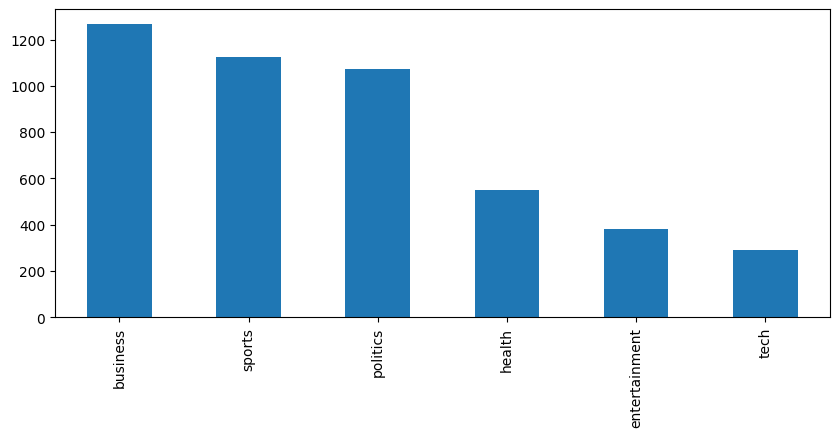

In [ ]:
my_tags = ['sports', 'business', 'politics', 'health', 'tech',
       'entertainment']
plt.figure(figsize=(10,4))
df.Category.value_counts().plot(kind='bar');

In [ ]:
df_test = pd.DataFrame(dataset['test'])

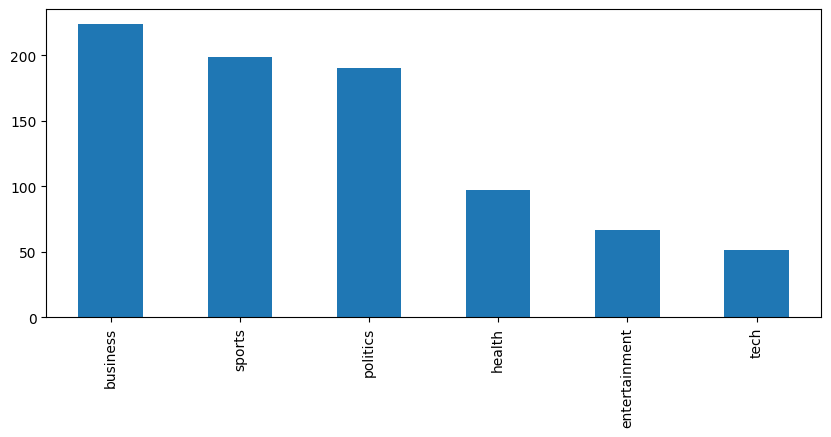

In [ ]:
my_tags = ['sports', 'business', 'politics', 'health', 'tech',
       'entertainment']
plt.figure(figsize=(10,4))
df_test.Category.value_counts().plot(kind='bar');

*If the disparity between the training and testing data for the categories was significant or the model is intend for real world scenarios, various techniques such as adding more data or data augmentation would need to be applied to fix the disparity*


In [ ]:
X = df.combined_text
y = df.Category
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

Trying different algorithms to see which has the best accuracy

### Naive Bayes Classifier for Multinomial Models

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import confusion_matrix, classification_report

nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', MultinomialNB())])

In [ ]:
%%time
from sklearn.metrics import classification_report
y_pred = nb.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))

accuracy 0.7930298719772404
               precision    recall  f1-score   support

       sports       0.66      0.95      0.78       390
     business       1.00      0.24      0.39       116
     politics       0.99      0.55      0.70       168
       health       0.86      0.94      0.90       310
         tech       0.86      0.98      0.92       338
entertainment       0.00      0.00      0.00        84

     accuracy                           0.79      1406
    macro avg       0.73      0.61      0.62      1406
 weighted avg       0.78      0.79      0.75      1406

CPU times: user 153 ms, sys: 1.51 ms, total: 155 ms
Wall time: 175 ms


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
conf_matrix_nb = confusion_matrix(y_test, y_pred)

In [ ]:
df_test.Category.value_counts()

business         224
sports           199
politics         190
health            97
entertainment     67
tech              51
Name: Category, dtype: int64

### Linear Support Vector Machine

In [ ]:
from sklearn.linear_model import SGDClassifier

sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
sgd.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf',
                 SGDClassifier(alpha=0.001, max_iter=5, random_state=42,
                               tol=None))])

In [ ]:
%%time

y_pred = sgd.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))

accuracy 0.8563300142247511
               precision    recall  f1-score   support

       sports       0.80      0.85      0.82       390
     business       0.87      0.78      0.82       116
     politics       0.87      0.82      0.85       168
       health       0.87      0.93      0.90       310
         tech       0.95      0.98      0.96       338
entertainment       0.54      0.31      0.39        84

     accuracy                           0.86      1406
    macro avg       0.82      0.78      0.79      1406
 weighted avg       0.85      0.86      0.85      1406

CPU times: user 102 ms, sys: 0 ns, total: 102 ms
Wall time: 102 ms


In [ ]:
conf_matrix_svm = confusion_matrix(y_test, y_pred)

### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5)),
               ])
logreg.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(C=100000.0, n_jobs=1))])

In [ ]:
%%time

y_pred = logreg.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))

accuracy 0.8620199146514936
               precision    recall  f1-score   support

       sports       0.82      0.83      0.82       390
     business       0.82      0.84      0.83       116
     politics       0.87      0.83      0.85       168
       health       0.90      0.94      0.92       310
         tech       0.97      0.97      0.97       338
entertainment       0.49      0.43      0.46        84

     accuracy                           0.86      1406
    macro avg       0.81      0.80      0.81      1406
 weighted avg       0.86      0.86      0.86      1406

CPU times: user 116 ms, sys: 0 ns, total: 116 ms
Wall time: 121 ms
